# Import

In [1]:
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score, silhouette_score
import optuna
from joblib import Parallel, delayed
from utils.Loader import NEUDataset
from utils.Perspectiver import Perspectiver
from source.Prototype1 import Prototype1

from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam

import multiprocessing
import torch
from mpl_toolkits.mplot3d import Axes3D
from skimage.restoration import denoise_wavelet
import random
import math
from PIL import Image
from collections import deque
import numpy as np
from scipy.ndimage import maximum_filter, minimum_filter, label, generate_binary_structure
from concurrent.futures import ProcessPoolExecutor, as_completed
from scipy.ndimage import label as ndi_label, binary_dilation

/home/liingfeng/Desktop/pytorch/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Init Variables

In [3]:
model = Prototype1(num_attention_heads=16).to("cuda")
if torch.cuda.is_available():
    print("Using cuda cores")
    model.cuda()

dataset = NEUDataset(set="train", seed=555, scale=0.5, best_param=True)

Using cuda cores
Dataset: train created!


# Hyper parameters

In [4]:
LEARNING_RATE = 0.0005
EPOCH = 1000
BATCH_SIZE = len(dataset)//2
THREADS = 8

# Training process
Best loss: '2532'

In [5]:
criterion = nn.MSELoss(reduction="sum")
optimizer = Adam(model.parameters(), lr=LEARNING_RATE)
dataloader = DataLoader(dataset=dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=THREADS)

In [6]:
def train(model):
    loss_record = []
    for epoch in range(EPOCH):
        model.train()
        total_loss = 0
        num_batches = 0

        # Desempaquetar ignorando 'labels'
        for images, _, best_parameters in dataloader:
            images = images.to('cuda')
            best_parameters = best_parameters.to('cuda')

            # Forward: el modelo predice sp y sr
            pred_reg = model(images)  # salida de regresión

            # Calcular la pérdida de regresión
            loss = criterion(pred_reg, best_parameters)
            total_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            num_batches += 1

        avg_loss = total_loss / num_batches
        loss_record.append(avg_loss)
        print(f"Epoch [{epoch + 1}/{EPOCH}], Loss: {avg_loss:.4f}")
    return loss_record, model

loss, model = train(model)

Epoch [1/1000], Loss: 1139625.1071
Epoch [2/1000], Loss: 1139339.0103
Epoch [3/1000], Loss: 1138862.3205
Epoch [4/1000], Loss: 1138078.1714
Epoch [5/1000], Loss: 1137265.7633
Epoch [6/1000], Loss: 1136437.0879
Epoch [7/1000], Loss: 1135297.5531
Epoch [8/1000], Loss: 1133808.3857
Epoch [9/1000], Loss: 1131679.3919
Epoch [10/1000], Loss: 1128582.5908
Epoch [11/1000], Loss: 1124159.9932
Epoch [12/1000], Loss: 1117293.5059
Epoch [13/1000], Loss: 1107810.4363
Epoch [14/1000], Loss: 1093244.4298
Epoch [15/1000], Loss: 1068918.6074
Epoch [16/1000], Loss: 1031528.0395
Epoch [17/1000], Loss: 977559.3440
Epoch [18/1000], Loss: 903636.7770
Epoch [19/1000], Loss: 805030.7239
Epoch [20/1000], Loss: 677065.0303
Epoch [21/1000], Loss: 525427.6857
Epoch [22/1000], Loss: 412670.9631
Epoch [23/1000], Loss: 377603.6056
Epoch [24/1000], Loss: 355409.9962
Epoch [25/1000], Loss: 354137.8978
Epoch [26/1000], Loss: 359272.6834
Epoch [27/1000], Loss: 354599.6678
Epoch [28/1000], Loss: 354673.1180
Epoch [29/100

In [7]:
total_parametros = sum(p.numel() for p in model.parameters())
print(f"Model parameters: {total_parametros}")

Model parameters: 535299


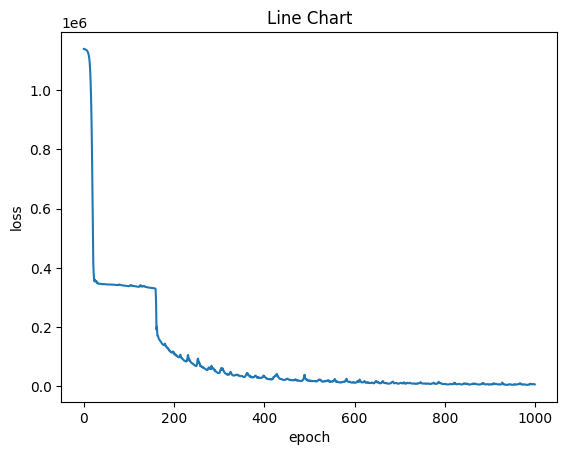

In [8]:
plt.plot(loss)           
plt.title("Line Chart")  
plt.xlabel("epoch")     
plt.ylabel("loss")      
plt.show()               

In [9]:
# Guardar solo la red neuronal en un archivo .pth
#torch.save(model.state_dict(), "h1.pth")
print("Modelo guardado exitosamente en h1.pth")

Modelo guardado exitosamente en h1.pth


In [10]:
loaded_model = Prototype1(num_attention_heads=16)
loaded_model.load_state_dict(torch.load("h1.pth", map_location=torch.device('cpu')))
loaded_model.to("cuda")
diff = 0
for i in range(len(dataset)):
    image , label, best_parameters = dataset.__getitem__(index=i)
    loaded_values  = loaded_model(image.to("cuda"))
    print(loaded_values)

tensor([[13.4464, 35.8563]], device='cuda:0', grad_fn=<ReluBackward0>)
tensor([[ 0.0000, 29.3601]], device='cuda:0', grad_fn=<ReluBackward0>)
tensor([[ 0.0000, 43.0936]], device='cuda:0', grad_fn=<ReluBackward0>)
tensor([[ 0.0000, 37.9586]], device='cuda:0', grad_fn=<ReluBackward0>)
tensor([[ 0.0000, 26.0141]], device='cuda:0', grad_fn=<ReluBackward0>)
tensor([[27.1164, 47.0687]], device='cuda:0', grad_fn=<ReluBackward0>)
tensor([[ 6.0227, 42.0703]], device='cuda:0', grad_fn=<ReluBackward0>)
tensor([[37.1992, 45.4741]], device='cuda:0', grad_fn=<ReluBackward0>)
tensor([[16.7518, 10.8169]], device='cuda:0', grad_fn=<ReluBackward0>)
tensor([[26.4268, 45.9747]], device='cuda:0', grad_fn=<ReluBackward0>)
tensor([[ 0.0000, 43.4739]], device='cuda:0', grad_fn=<ReluBackward0>)


/tmp/ipykernel_342528/1921535923.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load("h1.pth", map_location=torch.device('cpu')))


tensor([[11.5889,  3.6454]], device='cuda:0', grad_fn=<ReluBackward0>)
tensor([[ 1.6794, 35.3992]], device='cuda:0', grad_fn=<ReluBackward0>)
tensor([[37.4413, 45.9384]], device='cuda:0', grad_fn=<ReluBackward0>)
tensor([[11.3158, 47.3301]], device='cuda:0', grad_fn=<ReluBackward0>)
tensor([[41.4185, 45.3494]], device='cuda:0', grad_fn=<ReluBackward0>)
tensor([[ 9.1163, 35.0704]], device='cuda:0', grad_fn=<ReluBackward0>)
tensor([[ 0.0000, 27.0845]], device='cuda:0', grad_fn=<ReluBackward0>)
tensor([[23.4508, 48.8646]], device='cuda:0', grad_fn=<ReluBackward0>)
tensor([[ 4.6542, 26.9228]], device='cuda:0', grad_fn=<ReluBackward0>)
tensor([[25.4938, 44.9162]], device='cuda:0', grad_fn=<ReluBackward0>)
tensor([[ 0.0000, 59.5509]], device='cuda:0', grad_fn=<ReluBackward0>)
tensor([[ 0.0000, 43.7352]], device='cuda:0', grad_fn=<ReluBackward0>)
tensor([[ 0.0000, 48.5542]], device='cuda:0', grad_fn=<ReluBackward0>)
tensor([[ 7.8202, 47.9150]], device='cuda:0', grad_fn=<ReluBackward0>)
tensor

# Testing

In [ ]:
def plot_barchartImage(image):
    x = np.arange(image.shape[0])
    y = np.arange(image.shape[1])
    x, y = np.meshgrid(x, y)

    # Flatten arrays for plotting
    x = x.flatten()
    y = y.flatten()
    z = np.zeros_like(x)
    dx = dy = np.ones_like(x)
    dz = image.flatten()

    # Plot the 3D bar chart
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.bar3d(x, y, z, dx, dy, dz, shade=True)

    # Add labels and title
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Value')
    ax.set_title('3D Bar Chart of (200, 200) Array')

    plt.show()

In [11]:
test_set = NEUDataset(set="test", scale=0.5, seed=55)
print(len(test_set))

Dataset: test created!
72


In [26]:
image, label = test_set.__getitem__(index=5)
original_image = Perspectiver.grayscale_to_rgb(Perspectiver.normalize_to_uint8(image.detach().cpu().numpy()[0]))

In [27]:
def use_model_to_cluster(model: nn.Module, image: torch.tensor):
    best_parameters = model(image.to("cuda"))
    sp = best_parameters[0][0]
    sr = best_parameters[0][1]
    return sp, sr

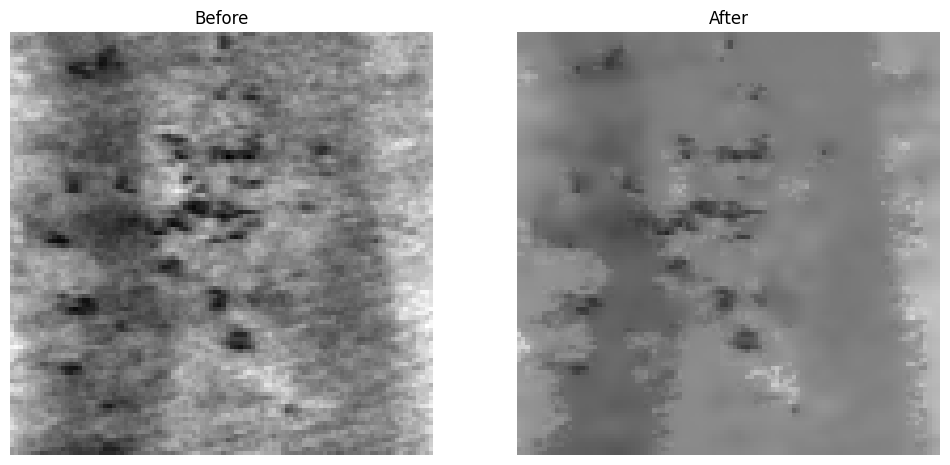

In [28]:
sp , sr = use_model_to_cluster(loaded_model, image)
clustered_image = Perspectiver.meanShift(original_image, float(sp), float(sr))
Perspectiver.plotComparison(imageBefore=original_image, imageAfter=clustered_image)

tensor(38.7567, device='cuda:0', grad_fn=<SelectBackward0>)

In [ ]:
best